In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

    * Accuracy: The proportion of correctly classified samples, i.e., the number of true positives and true negatives divided by the total number of samples. Accuracy is a common metric used to evaluate binary classification models. However, accuracy may not be the best metric for imbalanced datasets, where one class dominates the other.

    * Precision: The proportion of true positives among the predicted positive samples. Precision is the measure of how often the model correctly predicts a positive class. In the context of customer churn prediction, precision tells us how many of the customers who are predicted to churn will actually churn.

    * Recall: The proportion of true positives among the actual positive samples. Recall is the measure of how well the model correctly identifies all the positive samples. In the context of customer churn prediction, recall tells us how many of the customers who actually churned are correctly identified by the model.

    * F1 score: The harmonic mean of precision and recall. F1 score is a metric that combines precision and recall into a single score. It is a useful metric when we want to balance the trade-off between precision and recall.

These metrics are used to assess the performance of a classification model. as this is a binary classification task these metrics will help us know how our model is performing on our dataset. 

In this problem, we are more interested in identifying customers who are likely to churn, rather than accurately predicting which customers will stay with the company. Therefore, the recall metric is more important for achieving this goal.

Why the recall ? Maximizing recall is important for detecting as many customers who are likely to churn as possible, even if it means classifying some customers who will not actually churn as likely to churn. This trade-off is acceptable for the purpose of identifying customers who are at risk of churn and taking proactive measures to retain them.

In [188]:
churn_data = pd.read_csv("dataset.csv")
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [189]:
churn_data_copy = churn_data.copy(deep=True)

In [190]:
churn_data_copy.TotalCharges = pd.to_numeric(churn_data_copy.TotalCharges, errors='coerce')

Transformer to convert 'No phone service' and 'No internet service' to 'No'

In [114]:
class NoServiceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed.replace({"No phone service": "No", "No internet service": "No"},inplace=True)
        return X_transformed

In [115]:
churn_data_copy[churn_data_copy.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


TenureImputer will change tenure values equal to 0 with the median value of tenure based on contract type.  

In [116]:
class TenureImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        two_year = X_transformed[(X_transformed.Contract=="Two year")]["tenure"].median()
        one_year = X_transformed[(X_transformed.Contract=="One year")]["tenure"].median()
        one_month = X_transformed[(X_transformed.Contract=="Month-to-Month")]["tenure"].median()
        X_transformed.loc[(X_transformed.tenure==0)&(X_transformed.Contract=="Two year"),"tenure"]= two_year
        X_transformed.loc[(X_transformed.tenure==0)&(X_transformed.Contract=="One year"),"tenure"]= one_year
        X_transformed.loc[(X_transformed.tenure==0)&(X_transformed.Contract=="Month-to-Month"),"tenure"]= one_month
        return X_transformed


For totalCharges with missing values instead of getting rid of them we can actually make the product of tenure by monthlycharge which give us the totalcharges

In [155]:
class TotalChargesImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        nan_rows = X_transformed['TotalCharges'].isna()
        if nan_rows.any():
            nan_tenure = X_transformed.loc[nan_rows, 'tenure']
            nan_monthlycharges = X_transformed.loc[nan_rows, 'MonthlyCharges']
            X_transformed.loc[nan_rows, 'TotalCharges'] = nan_tenure * nan_monthlycharges
        return X_transformed

After our deep analysis we notice that 'customerID', 'gender' and 'phoneService' are not relevant for the model to learn to predict if a given customer churned or not.

In [13]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed = X_transformed.drop(["customerID","gender","PhoneService"],axis=1)
        return X_transformed

Convert values equals to Yes in 1 and No in 0

In [28]:
class YesNoToBinary(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed.replace({'Yes': 1, 'No': 0}, inplace=True)
        return X_transformed

Create dummy variable

In [82]:
class GetDummies(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed = pd.get_dummies(data=X_transformed, columns=['InternetService', 'Contract', 'PaymentMethod' ])
        return X_transformed

Help us apply the MinMaxScaler more easily by taking the columns to be scaled and the scaler.

In [186]:
class ColumnScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns, scaler):
        self.columns = columns
        self.scaler = scaler
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.columns] = self.scaler.transform(X[self.columns])
        return X_transformed


here is the pipeline

In [187]:
pipeline = Pipeline([
    ('no_service_transformer', NoServiceTransformer()),
    ('tenure_imputer', TenureImputer()),
    ('total_charges_imputer', TotalChargesImputer()),
    ('feature_selector', FeatureSelector()),
    ('yes_no_to_binary', YesNoToBinary()),
    ('get_dummies', GetDummies()),
    ('min_max', ColumnScaler(columns=['tenure', 'MonthlyCharges', 'TotalCharges'], scaler=MinMaxScaler())),
])

In [191]:
churn_data_copy = pipeline.fit_transform(churn_data_copy)

In [192]:
churn_data_copy.isna().sum()

SeniorCitizen                              0
Partner                                    0
Dependents                                 0
tenure                                     0
MultipleLines                              0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
InternetService_0                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_Two year                          0
PaymentMethod_Bank transfer (automatic)    0
PaymentMet

In [193]:
X = churn_data_copy.drop("Churn",axis=1)
Y = churn_data_copy["Churn"]

In [194]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score
from sklearn.model_selection import learning_curve, train_test_split

In [195]:
X_train, X_test, Y_train, Y_test = train_test_split (X,Y, test_size=0.1, random_state=42)

In [212]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [224]:
logistique = LogisticRegression()
svm_classifier = LinearSVC()
svm_poly_classifier = SVC(C= 5, coef0= 1, degree= 4, kernel= 'poly')
ada_classifier = AdaBoostClassifier()
gradient_classifier = GradientBoostingClassifier()

In [205]:
def model_evaluation(model):
    model.fit(X_train, Y_train)
    N, train_score, val_score = learning_curve(model,X_train,Y_train, cv=4, scoring='recall')
    ypred=model.predict(X_test)
    print(confusion_matrix(Y_test,ypred))
    print(classification_report(Y_test,ypred))
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),label='train score')
    plt.plot(N,val_score.mean(axis=1),label='val score')
    plt.legend()

In [225]:
list_of_models = {'logistique':logistique,
                  'ada_classifier':ada_classifier,
                  'svm_classifier':svm_classifier,
                  'gradient_classifier':gradient_classifier,
                  'svm_poly_classifier':svm_poly_classifier}

logistique
[[464  47]
 [ 79 115]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       511
           1       0.71      0.59      0.65       194

    accuracy                           0.82       705
   macro avg       0.78      0.75      0.76       705
weighted avg       0.81      0.82      0.82       705

ada_classifier
[[465  46]
 [ 84 110]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       511
           1       0.71      0.57      0.63       194

    accuracy                           0.82       705
   macro avg       0.78      0.74      0.75       705
weighted avg       0.81      0.82      0.81       705

svm_classifier
[[466  45]
 [ 81 113]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       511
           1       0.72      0.58      0.64       194

    accuracy                           0.82       705
   macro avg      

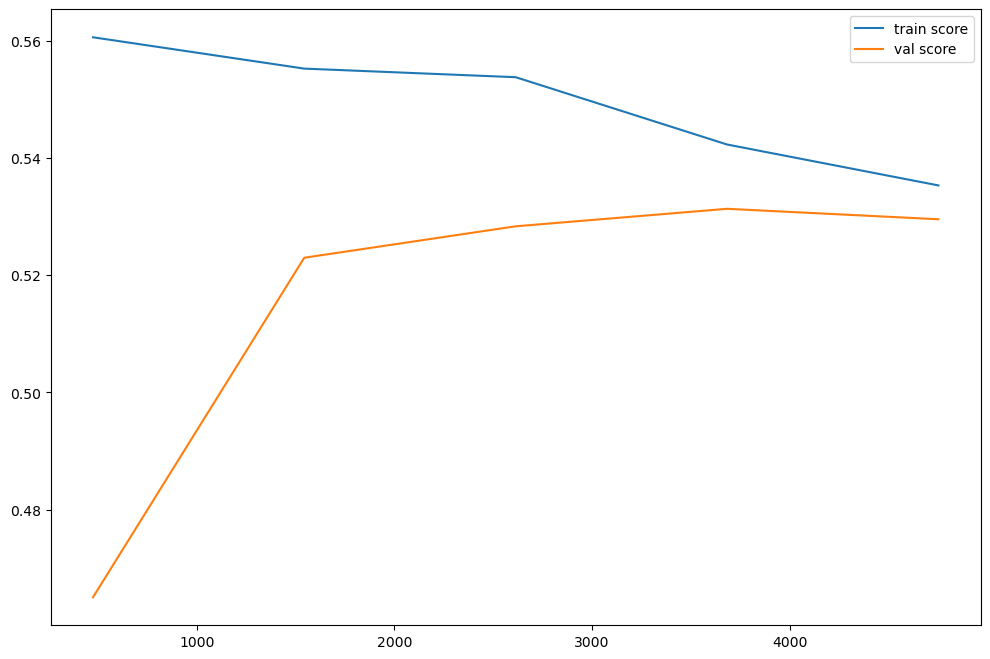

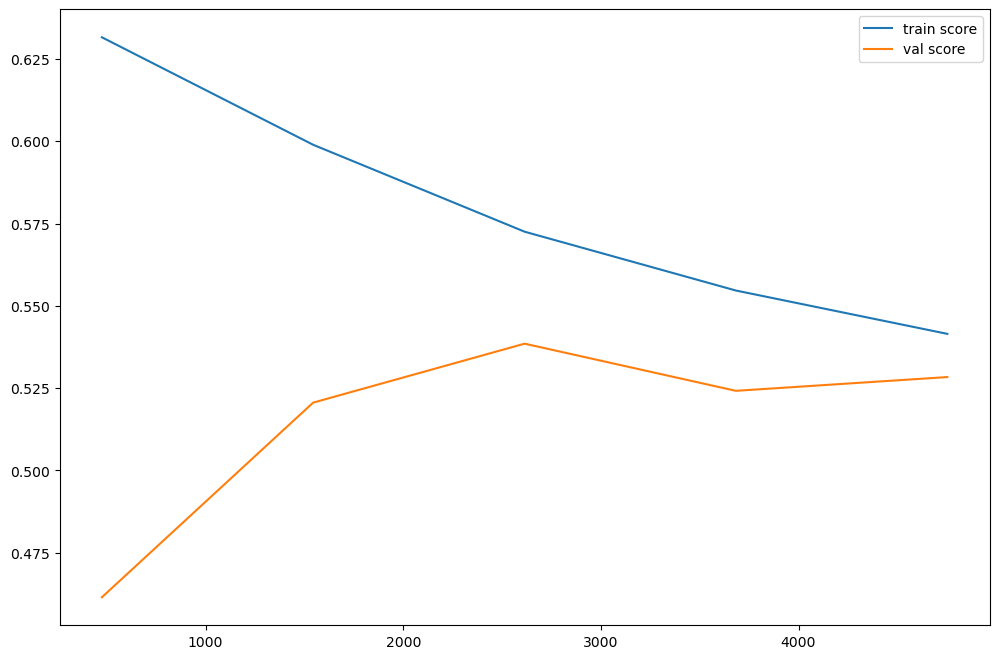

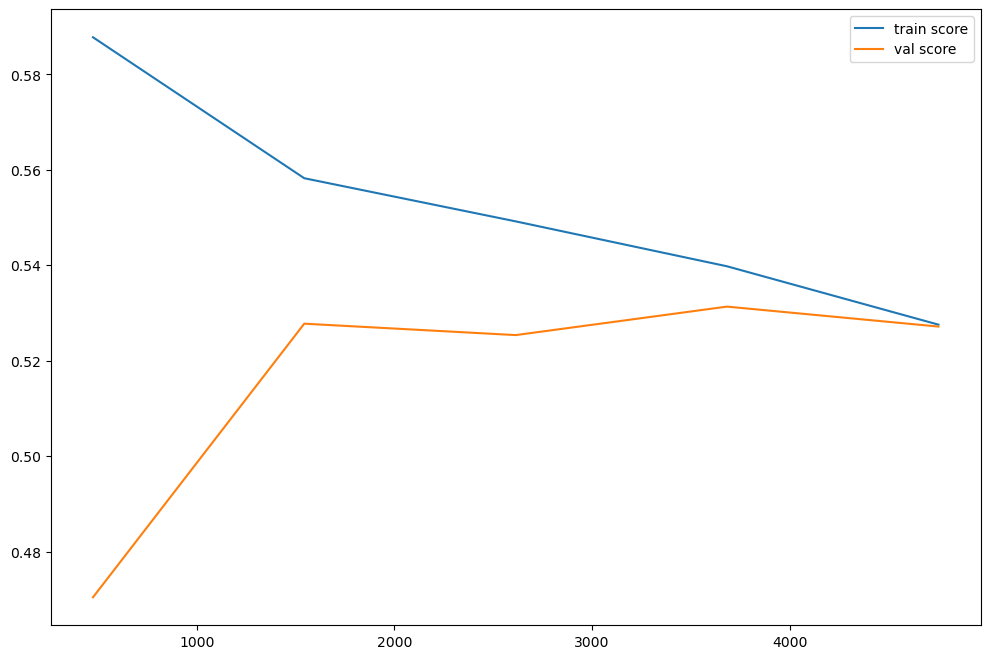

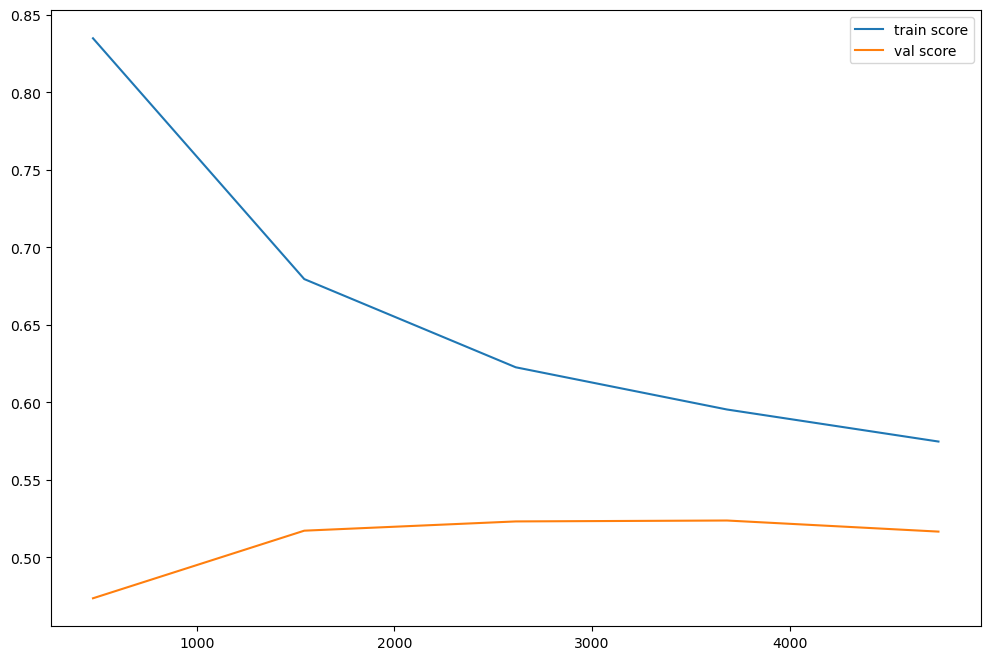

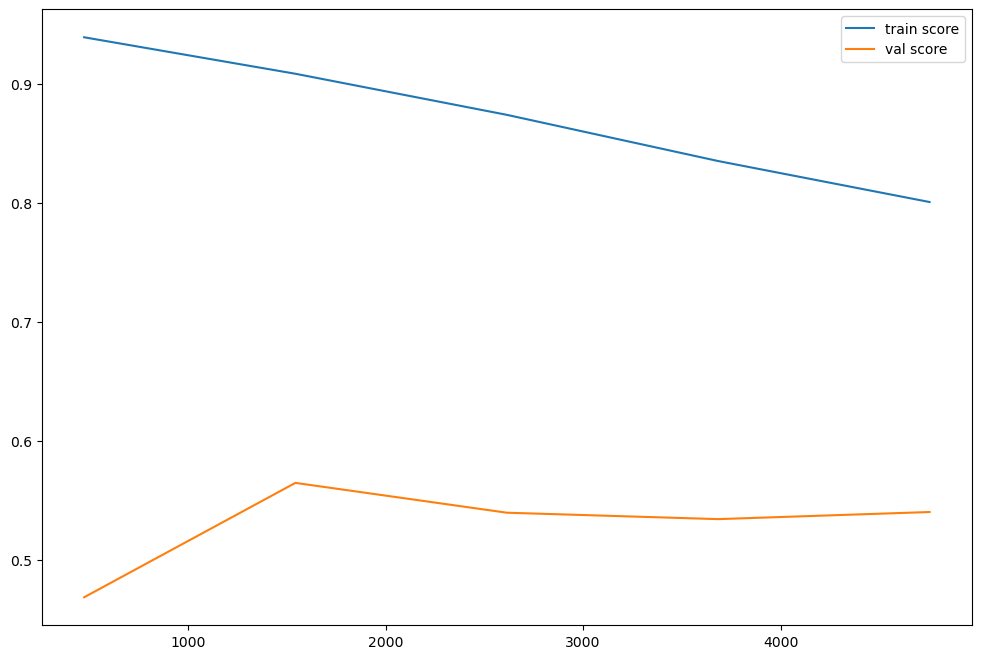

In [226]:
for name,model in list_of_models.items():
    print(name)
    model_evaluation(model)

According to the following insight we may notice that only tenure, MonthlyCharges, totalCharges, Contract_fiber-obpric, Contract-month-to-month and payment_method are relevant for making prediction.

<AxesSubplot:>

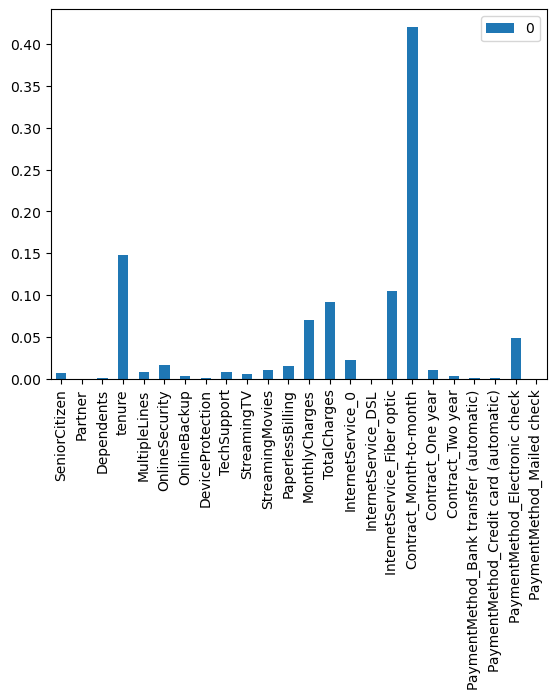

In [207]:
pd.DataFrame(model.feature_importances_,index=X_train.columns).plot.bar()

The best model is logistic because it can detect in general 65% of people who actually churned. this is much better than other ones.

In [208]:
from sklearn.model_selection import GridSearchCV

In [228]:
# Logistique hyperparameter
hyper_param = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'penalty':['l2'],
                'C':[100, 10, 1.0, 0.1, 0.01]}

In [229]:
def best_hyper(model,hyper_p):
    grid = GridSearchCV(model,hyper_p,cv=4,scoring='recall')
    grid.fit(X_train,Y_train)
    print(grid.best_params_)
    y_pred = grid.predict(X_test)
    print(confusion_matrix(Y_test,y_pred))
    print(classification_report(Y_test,y_pred))
    return grid

In [312]:
grid=best_hyper(logistique,hyper_param)

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
[[462  49]
 [ 78 116]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       511
           1       0.70      0.60      0.65       194

    accuracy                           0.82       705
   macro avg       0.78      0.75      0.76       705
weighted avg       0.81      0.82      0.82       705



In [232]:
from sklearn.metrics import precision_recall_curve

In [306]:
precision, recall, threshold = precision_recall_curve(Y_test, grid.best_estimator_.decision_function(X_test))

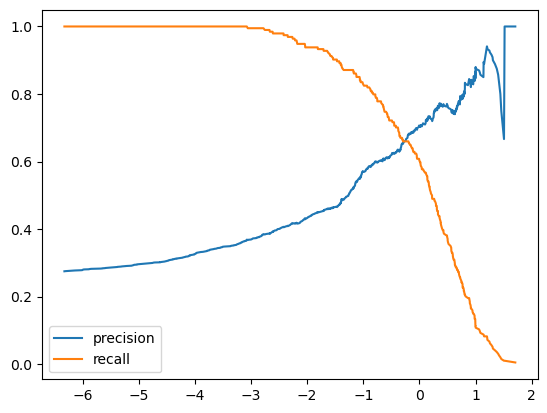

In [307]:
plt.plot(threshold, precision[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()

For the purpose of our company it will be better if we set the threshold to -1.5. This will raise the recall ( detect almost all customers who curned)

In [349]:
class FinalModel:
    
    threshold = -1.5
    def __init__(self) -> None:
        self.__model = grid.best_estimator_
        
    def predict(self, X):
        X_values = self.__model.decision_function(X)
        return np.where(X_values > self.threshold, 1, 0)
    
final_model = FinalModel()
y_pred = final_model.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,

In [238]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [342]:
recall_score(Y_test, y_pred)

0.9020618556701031

In [343]:
precision_score(Y_test, y_pred)

0.4666666666666667

In [345]:
f1_score(Y_test, y_pred)

0.6151142355008787